# Introduction

La siguiente libreta contiene los procedimientos y comentarios para el Exploratory Data Analysis (EDA) cuyo fin es el de obtener insights referentes a la distribución de los atributos y encontrar posibles patrones relevantes para la predicción. 

First, a basic exploration of the data is performed to determine whether it is necessary to perform a Data Wrangling to homogenize the data types in each feature and target, and also to describe the data using basic descriptive statistics in order to begin to understand the data available and possible complications for learning the model. The above is exposed in the section [First Exploration](#2-first-exploration), being the most relevant that the number of instances are balanced with respect to the target (``Growth_Milestone``).

# 0. Import Libraries and Other Code

In [2]:
# Relevant Libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import re

from typing import Callable , Any

In [3]:
# Defining custom color palette and maps

Color_Palette = ['lightgreen','darkgreen']
Color_Map = LinearSegmentedColormap.from_list("Color_Map",Color_Palette,N=20)

In [4]:
def GetFeatureName(Feature:str) -> str:
    """
        Function for getting feature's name 
        of a feature
    """
    return re.sub(r'_',' ',Feature)

In [5]:
def PlotDistributionsByTarget(Dataset:pd.DataFrame,Features:list[str],Target:str,TypePlot:Callable,FeatureTypeName:str,AdditionalPlotArgs:dict={}) -> None:
    """
        Function for plotting distribution of features 
        by value of target
    """
    mosaic_grid = "1122\n.33."
    fig , axes = plt.subplot_mosaic(mosaic_grid,figsize=(8,6),layout='tight')

    for index_axes , feature in enumerate(Features,1):
        axes_plot = axes[str(index_axes)]
        TypePlot(Dataset,x=feature,hue=Target,palette=Color_Palette,ax=axes_plot,legend=False,**AdditionalPlotArgs)
        axes_plot.set_xlabel(GetFeatureName(feature))

    fig.suptitle(f'Distribution of {FeatureTypeName} Features')
    fig.legend(title='Growth Milestone',labels=['No Milestone','Milestone'],loc=(0.05,0.35))

In [6]:
def PlotCorelationMatrixByValueTarget(Dataset:pd.DataFrame,NumericalFeatures:list[str],Target:str,ValueTarget:Any,MeaningValue:str) -> None:
    """
        Function for plotting correlation between 
        features
    """
    fig , axes = plt.subplots()

    correlation_matrix = Dataset.query(f"{Target} == @ValueTarget")[NumericalFeatures].corr()
    sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True,cmap=Color_Map,ax=axes)

    fig.suptitle(' '.join([MeaningValue,GetFeatureName(Target)]))

# 1. Load Dataset 

In [7]:
# Loading dataset

PlantGrowth_Dataset = pd.read_csv("plant_growth_data.csv")

print(f'Dataset shape is: {PlantGrowth_Dataset.shape}')

# Example of records
PlantGrowth_Dataset.head(5)

Dataset shape is: (193, 7)


,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


# 2. First Exploration

The different features and targets have the expected data types from the dataset description in [[1]](#references) so it is not necessary to reformat them, likewise there are no missing values in any of the attributes.

The three numerical attributes follow different ranges of values, so the values have to be standardized to make a comparison between them. Therefore, it is necessary to standardize the values in order to make a comparison between them. In doing so, they follow different distributions using only the quartiles, so it could be expected that these attributes come from different phenomena or interactions. The ``Sunlight_Hours`` attribute appears to follow a more normal distribution, because its median $Q_2$ is almost $0$ while its quartiles $Q_1$ and $Q_3$ are almost the same except for the sign. About the ``Humidity`` attribute, its median $Q_2$ is not so close to $0$ but instead is equidistant to its other quartiles, so it is unskewed. While the ``Temperature`` attribute tends to have a negative skewness, so temperatures will tend to be higher with respect to the mean.

Each categorical attribute has three unique values. The ``Soil_Type`` attribute has its three balanced values, that is, they have the same number of instances per value, so the model will have enough different instances to distinguish between possible cases. For the attributes ``Water_Frequency`` and ``Fertilizer_Type`` an imbalance in the instances per value can be observed, this could be related to the fact that possibly not enough experiments were generated with the values of these attributes to cover the different possibilities.

There are the same number of instances for both classes of the target (``Growth_Milestone``), so the learning of the model will be able to capture, to some extent, the relevant relationships to distinguish between classes, this a priori. The latter could be false due to the unbalance of categorical attributes, unless they follow a noticeable pattern according to the class of ``Growth_Milestone``.

In [8]:
# Data types of variables

PlantGrowth_Dataset.dtypes

Soil_Type            object
Sunlight_Hours      float64
Water_Frequency      object
Fertilizer_Type      object
Temperature         float64
Humidity            float64
Growth_Milestone      int64
dtype: object

In [9]:
# Splitting variables into numerical and categorical

labels_variables = PlantGrowth_Dataset.columns

Features = labels_variables[:-1]
Target = labels_variables[-1]

NumericalFeatures , CategoricalFeatures = [] , []
for feature in Features:
    if PlantGrowth_Dataset[feature].dtype == 'object':
        CategoricalFeatures.append(feature)
    else:
        NumericalFeatures.append(feature)

In [10]:
# Basic descriptive : Numerical features

PlantGrowth_Dataset[NumericalFeatures].describe()

,Sunlight_Hours,Temperature,Humidity
count,193.000000,193.000000,193.000000
mean,6.826484,25.076087,58.098927
std,1.599509,5.354170,12.631799
min,4.033133,15.200000,30.567682
25%,5.477000,20.637095,49.300000
50%,6.833290,25.912336,59.182806
75%,8.241144,29.757938,69.100000
max,9.913903,34.810103,79.648240


In [ ]:
# Basic descriptive : Numerical features -- Standardization

PlantGrowth_Dataset[NumericalFeatures].apply(lambda values : (values - np.mean(values))/np.std(values),axis=0).describe()

,Sunlight_Hours,Temperature,Humidity
count,1.930000e+02,1.930000e+02,1.930000e+02
mean,1.472627e-16,-4.279823e-16,8.283529e-17
std,1.002601e+00,1.002601e+00,1.002601e+00
min,-1.750923e+00,-1.849357e+00,-2.185187e+00
25%,-8.458811e-01,-8.312280e-01,-6.983812e-01
50%,4.265630e-03,1.565927e-01,8.602874e-02
75%,8.867342e-01,8.767051e-01,8.731682e-01
max,1.935250e+00,1.822754e+00,1.710394e+00


In [30]:
# Basic descriptive : Categorical features

PlantGrowth_Dataset[CategoricalFeatures].describe()

,Soil_Type,Water_Frequency,Fertilizer_Type
count,193,193,193
unique,3,3,3
top,clay,daily,none
freq,67,74,74


In [29]:
# Basic descriptive : Categorical features -- Soil_Type

PlantGrowth_Dataset[CategoricalFeatures[0]].value_counts()

Soil_Type
clay     67
sandy    64
loam     62
Name: count, dtype: int64

In [ ]:
# Basic descriptive : Categorical features -- Water_Frequency

PlantGrowth_Dataset[CategoricalFeatures[1]].value_counts()

Water_Frequency
daily        74
bi-weekly    60
weekly       59
Name: count, dtype: int64

In [ ]:
# Basic descriptive : Categorical features -- Fertilizer_Type

PlantGrowth_Dataset[CategoricalFeatures[2]].value_counts()

Fertilizer_Type
none        74
chemical    65
organic     54
Name: count, dtype: int64

In [13]:
# Basic descriptive : Target

PlantGrowth_Dataset[Target].value_counts()

Growth_Milestone
0    97
1    96
Name: count, dtype: int64

# Distribution of Features

From the plots, it can be seen that the attributes follow different distributions, although there is some overlapping, making there a certain tendency (in the attributes) at the moment of evaluating whether there is significant growth.

Noting that for significant growth to occur the hours of sunlight and humidity must be in an optimal range, in addition to fertilizer being used on the plant.

## Numerical Features

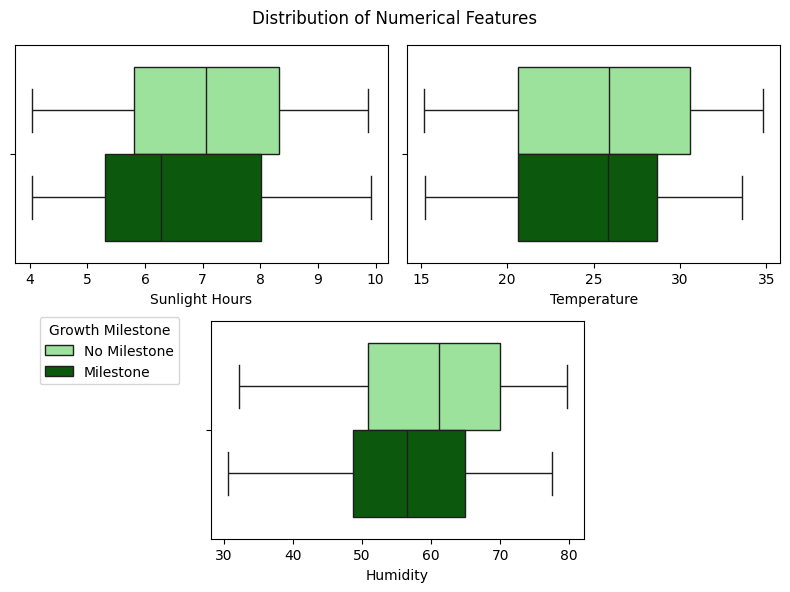

In [11]:
PlotDistributionsByTarget(PlantGrowth_Dataset,NumericalFeatures,Target,sns.boxplot,'Numerical')

## Categorical Features

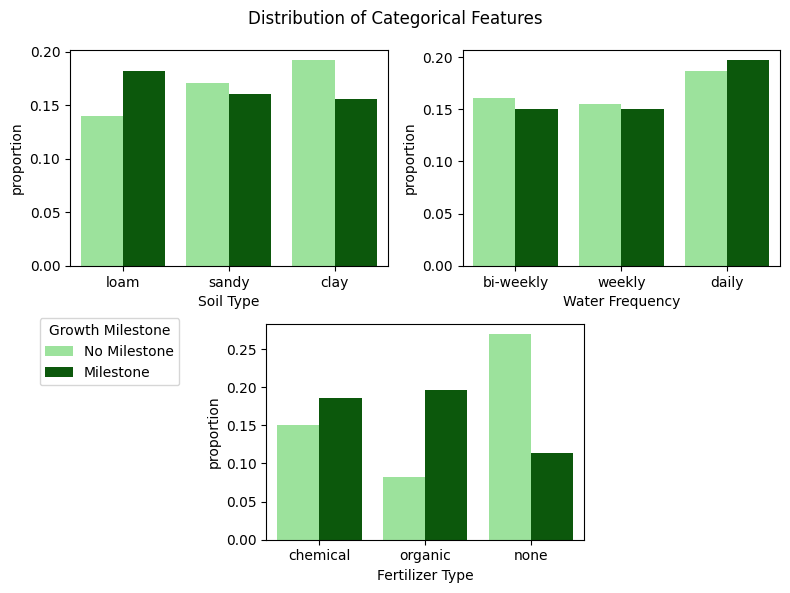

In [12]:
PlotDistributionsByTarget(PlantGrowth_Dataset,CategoricalFeatures,Target,sns.countplot,'Categorical',{'stat':'proportion'})

# Correlation of Numerical Features

The correlation matrices show the following trends in attributes:

* No significant growth: Sunlight hours have a negative correlation with temperature and humidity. This could be related to how sunlight was used to compensate for low ambient temperatures or a very humid environment.

* With significant growth: Temperatures have a positive correlation with humidity. This relates to optimal environments for some plants.

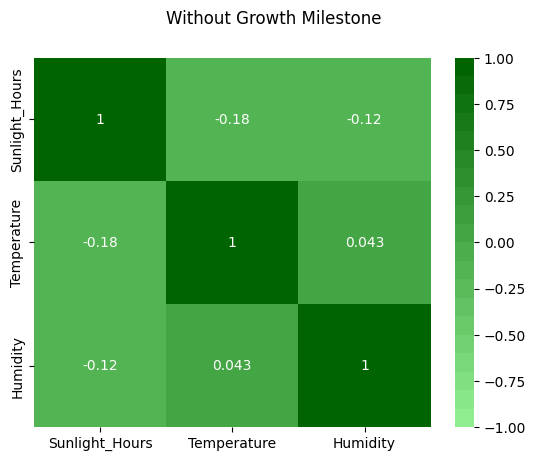

In [13]:
PlotCorelationMatrixByValueTarget(PlantGrowth_Dataset,NumericalFeatures,'Growth_Milestone',0,'Without')

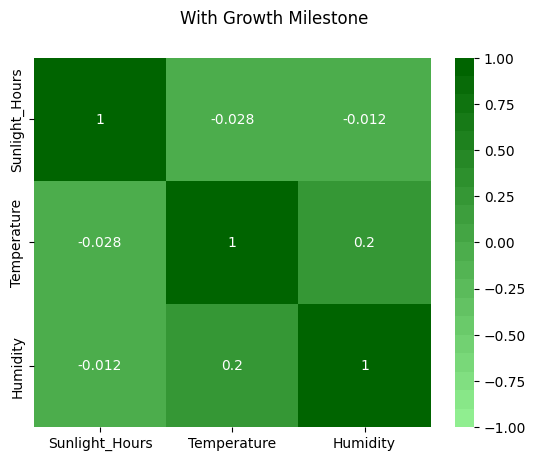

In [14]:
PlotCorelationMatrixByValueTarget(PlantGrowth_Dataset,NumericalFeatures,'Growth_Milestone',1,'With')

# Hypothesis Testing

Se prueban algunas hipótesis con el fin de obtener insights extras sobre el dataset. Las hipótesis a probar son:

1. Los atributos numéricos siguen diferentes distribuciones según la presencia de crecimiento significativo

2. Los atributos categóricos son dependientes de la presencia de crecimiento significativo

## Hypothesis about Numerical Features

## Hypothesis about Categorical Features

# References

* [1] Plant Growth Data Classification. Kaggle, [gortorozyannnn](https://www.kaggle.com/gorororororo23). https://www.kaggle.com/datasets/gorororororo23/plant-growth-data-classification